In [1]:
# Install required libraries
%pip install torch torchaudio transformers datasets[audio] scikit-learn numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
def convert_to_target(emotion):
    if emotion == 'euphoric':
        return 1
    elif emotion == 'joyfully':
        return 2
    elif emotion == 'sad':
        return 3
    elif emotion == 'surprised':
        return 4
    else:
        return -1

In [4]:
# Load dataset
audio_dataset = load_dataset(
    'TrainingDataPro/speech-emotion-recognition-dataset',
    split='train'
)

# Load CLAP model
model = ClapModel.from_pretrained('laion/larger_clap_music').to('cuda:0')
processor = ClapProcessor.from_pretrained('laion/larger_clap_music')

# Preprocess audio samples
emotions = ['euphoric', 'joyfully', 'sad', 'surprised']
sample_inputs = []
audio_embeddings = []
targets = []

SAMPLING_RATE = 48000

for emotion in emotions:
    for sample in audio_dataset[emotion]:
        sample_inputs.append(
            processor(
                audios=sample['array'],
                sampling_rate=SAMPLING_RATE,
                return_tensors='pt'
            ).to('cuda:0')
        )
        targets.append(convert_to_target(emotion))

for inputs in sample_inputs:
    audio_embeddings.append(model.get_audio_features(**inputs))
    
torch.save(audio_embeddings, 'audio_embeddings.pt')

In [5]:
# Flatten embeddings
flattened_embeddings = [embedding.view(-1) for embedding in audio_embeddings]
embedding_matrix = torch.stack(flattened_embeddings)

# Convert embeddings from tensor to numpy arrays
embedding_matrix = embedding_matrix.detach().cpu().numpy()
print(embedding_matrix.shape)
print(embedding_matrix)

(80, 512)
[[-0.0197334  -0.00249679  0.11328787 ... -0.08363502  0.04762014
   0.08813638]
 [-0.01700936 -0.00169819  0.12584828 ... -0.08392757  0.05042014
   0.0900396 ]
 [-0.01665157 -0.00179881  0.11708343 ... -0.0858629   0.04423774
   0.08991268]
 ...
 [-0.01731364 -0.00215796  0.11473525 ... -0.0838877   0.04435505
   0.08995587]
 [-0.01807118 -0.00259435  0.11262784 ... -0.08339463  0.04653695
   0.08947439]
 [-0.01466641 -0.00274683  0.1172166  ... -0.08552615  0.04621886
   0.09083286]]


In [6]:
NUM_TRAINING = 15

def create_splits(data, targets):
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    
    for index in range(80):
        if index % 20 < NUM_TRAINING:
            train_data.append(data[index])
            train_targets.append(targets[index])
        else:
            test_data.append(data[index])
            test_targets.append(targets[index])
    
    return train_data, test_data, train_targets, test_targets

In [7]:
# Train Naive-Bayes classifier
X_train, X_test, y_train, y_test = create_splits(embedding_matrix, targets)

model = GaussianNB()
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(train_pred, y_train)
test_accuracy = accuracy_score(test_pred, y_test)
train_f1 = f1_score(train_pred, y_train, average="weighted")
test_f1 = f1_score(test_pred, y_test, average="weighted")

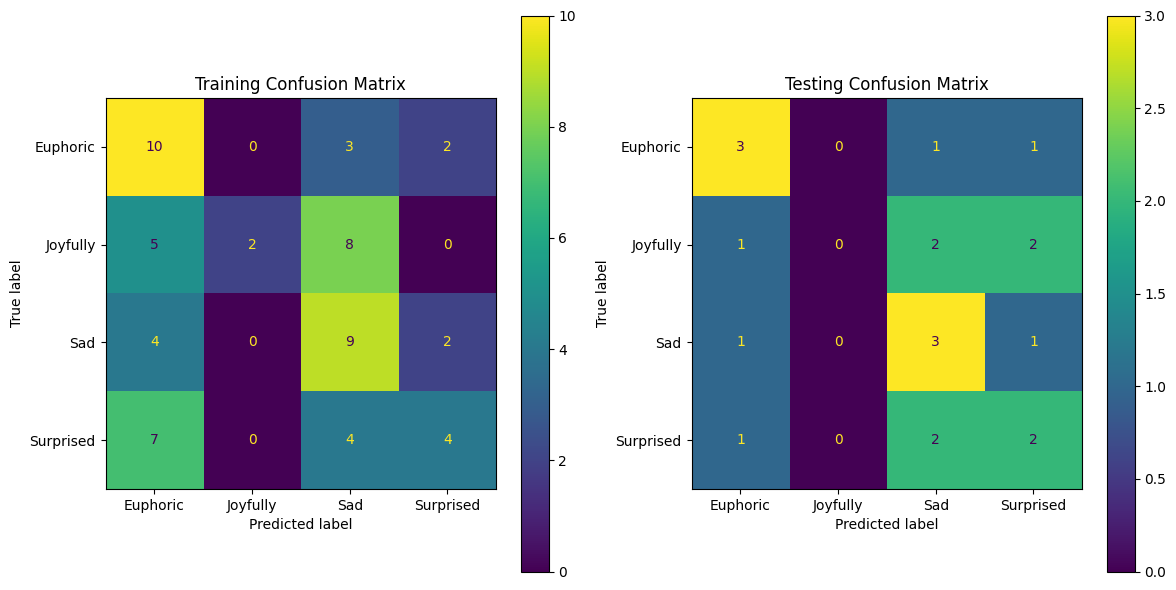

Training Accuracy: 0.41667
Testing Accuracy: 0.4
Training F-measure: 0.45022
Testing F-measure: 0.45734


In [8]:
# Visualize confusion matrices
labels = ['Euphoric', 'Joyfully', 'Sad', 'Surprised']

train_cm = confusion_matrix(y_train, train_pred, labels=[1, 2, 3, 4])
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=labels)

test_cm = confusion_matrix(y_test, test_pred, labels=[1, 2, 3, 4])
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
train_disp.plot(ax=ax[0])
ax[0].set_title("Training Confusion Matrix")
test_disp.plot(ax=ax[1])
ax[1].set_title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

# Print accuracy scores
print("Training Accuracy:", round(train_accuracy, 5))
print("Testing Accuracy:", round(test_accuracy, 5))
print("Training F-measure:", round(train_f1, 5))
print("Testing F-measure:", round(test_f1, 5))